In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

### Check npy

In [25]:
my_data_path = "data/202055133/arm_rfdata.npy"
refer_data_path = "data/phantom/phantom_rfdata.npy"

In [26]:
my_data = np.load(my_data_path)
refer_data = np.load(refer_data_path)

print("my_data.shape: ", my_data.shape, "refer_data.shape: ", refer_data.shape)

my_data.shape:  (2176, 128, 100) refer_data.shape:  (2176, 128, 100)


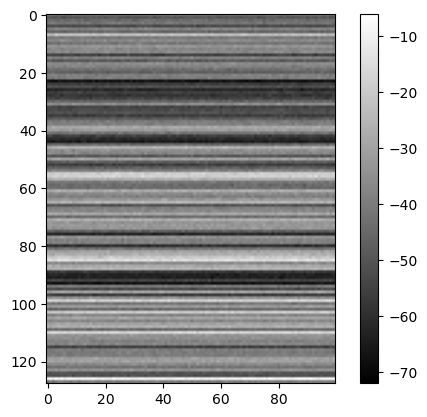

In [27]:
plt.imshow(my_data[0], cmap='gray')
plt.colorbar()
plt.show()

### Check Metadata

In [19]:
#want to read data/parameters.json file as dictionary

with open('data/parameters.json') as f:
    data = json.load(f)

data

{'samplingRate(MHz)': 31.6,
 'center frequency(MHz)': 7.6,
 'sampling rate(samples/wave)': 4.1,
 'speed of sound(m/s)': 1540,
 'speed of sound(phantom, m/s)': 1450,
 'spacing(mm)': 0.3,
 'output y(px)': 400,
 'output y(mm)': 40}

In [22]:
dx = data["spacing(mm)"]
# 400px = 4cm
dy = data["output y(mm)"]/data["output y(px)"]
print(dx, dy)

0.3 0.1


### check one of signal

In [28]:
target_num = 50
target_my_data = my_data[target_num]
target_refer_data = refer_data[target_num]

In [29]:
signal_my_i = target_data[:, 0]
print(signal_my_i.shape)

(128,)


/home/skyriver/anaconda3/envs/signal/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/skyriver/anaconda3/envs/signal/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


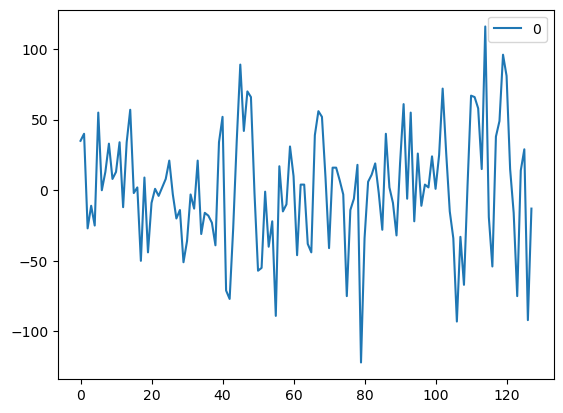

In [30]:
signal_my_i = np.reshape(target_my_data[:, 0], (128, 1))
sns.lineplot(data=signal_my_i)
plt.show()

/home/skyriver/anaconda3/envs/signal/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/skyriver/anaconda3/envs/signal/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


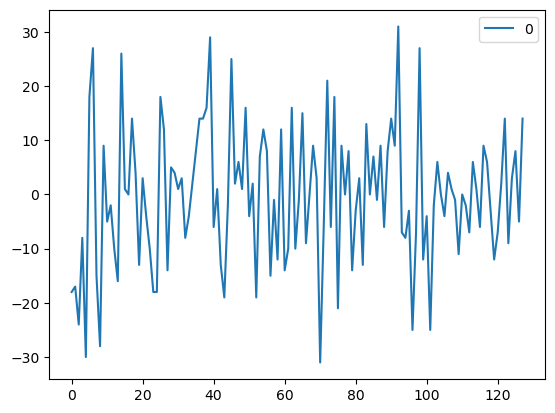

In [31]:
signal_refer_i = np.reshape(target_refer_data[:, 0], (128, 1))
sns.lineplot(data=signal_refer_i)
plt.show()


### DAS(delay and sum)

- 음파 변환기의 각 소자들에 서로 다른 지연 시간을 가하여 초음파 빔 방향을 바꿀 수 있다. 


- t=0에서 소자 $T_0$가 펄스를 생성한다고 가정
    - 평면파가 $\theta$ 방향으로 생성되기 위하여 다른 소자들에서 필요한 지연 시간을 계산
    - 시간 t가 되면 소자 $T_0$에서 발생한 파는 거리 $r_0(t) = ct$ 만큼 진행

- 음파 변환기의 i 번째 소자 $T_i$로부터 이 선까지의 거리는 
$$
r_i(t) = r_0(t) - id sin(\theta)
$$

- 따라서 파의 선두가 직선 $L(t, \theta)$가 되기 위하여 아래와 같은 시간 지연을 가지고 있어야 한다. 
$$
t_i = \frac{r_0(t) - r_i(t)}{c} = \frac{idsin(\theta)}{c}
$$

- 중심이 원점인 2N+1개의 소자로 된 음파변환기가 있어 아래와 같이 가정한다.  
$t_{min}=min{t_i, i = -N ~ N}$


- 시간 지연은 아래와 같다.  
$$
{\tau}_i = t_i - t_{min}, i=-N ~ N
$$

하지만 우리는 짝수개 이기 때문에 가장 왼쪽을 0으로 두고, N= 128로 생각하고 진행한다.
- 이에 따른 시간 지연은  
$$
{\tau}_i = t_i - t_{min}, i= 0 ~ N-1
$$

In [32]:
DAS_x = 1580
DAS_y = 128
DAS_data = np.zeros((DAS_x, DAS_y))

- i번째 소자에서 특정 위치 $(x_f, y_f)$까지의 거리  
    - d = spacing(센서간 거리)
$$
r_i = \sqrt{{id-x_f}^2 + y_f^2}
$$

- DAS_data에서 $T_i$까지의 거리
    - 예시로 x,y 위치와 3번째센서를 확인

In [23]:
i = 150 # 0~127
x, y = 300, 300
r = np.sqrt((i*d-x*dx)**2 + dy*y**2)
print(r)

105.0


In [24]:
128*d

38.4

- $T_0$에서 음파가 발생하는 시간을 t=0라 한다면, $T_i$에서는 다음의 시간에 음차가 발생하여야 동시에 초점으로 음파가 도달  
$$
t_i = \frac{r_0 - r_i}{c} = \frac{\sqrt{x_f^2 + y_f^2}- \sqrt{{id-x_f}^2 + y_f^2}}{c}
$$

고민 중인 부분
- samplingdmf 어떻게 하였는지? 평형파로 가정해야될까 아니면 1.92cm 지점(중간)에서 발생한 원형파로 봐야 할까?
    - 수업 시간 생각을 해보면 평형파로 가정 == (x,y)라는 지점에 도달하는 속도가 같다고 봐야할듯
